In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir, getcwd, chdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import operator
import xgboost as xgb
from xgboost.training import CVPack
from xgboost import callback
from xgboost.core import CallbackEnv
from xgboost.core import EarlyStopException
from xgboost.core import STRING_TYPES

import diff_predictor
from diff_predictor.data_process import *
from diff_predictor.predxgboost import train

import seaborn as sns

from tqdm import tqdm_notebook, tnrange


In [38]:
from azureml.core import Workspace, Dataset

subscription_id = '9c49afdd-cccb-44e2-a4eb-5b2f941c774c'
resource_group = 'schimek_cloud'
workspace_name = 'nels_east_us'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='P17_OGD_1div_CTX_features')
dataset.download(target_path='.', overwrite=False)

['/Users/nelsschimek/Documents/nancelab/diff_predictor/notebooks/azure_notebooks/features_P17_1h_OGD_1d_40nm_slice_1_cortex_vid_1.csv',
 '/Users/nelsschimek/Documents/nancelab/diff_predictor/notebooks/azure_notebooks/features_P17_2h_OGD_1d_40nm_slice_1_cortex_vid_1.csv',
 '/Users/nelsschimek/Documents/nancelab/diff_predictor/notebooks/azure_notebooks/features_P17_3h_OGD_1d_40nm_slice_1_cortex_vid_1.csv',
 '/Users/nelsschimek/Documents/nancelab/diff_predictor/notebooks/azure_notebooks/features_P17_NT_1d_40nm_slice_1_cortex_vid_1.csv']

In [39]:
datasetpath = getcwd()
print('generating filelist')
#filelist = [f for f in listdir(dataset.to_path()) if isfile(join(dataset.to_path(), f)) and 'feat' in f]
filelist = []
for file in dataset.to_path():
    filelist.append(file)
print('showing five path examples')
print(filelist[0:5])

generating filelist
showing five path examples
['/features_P17_1h_OGD_1d_40nm_slice_1_cortex_vid_1.csv', '/features_P17_2h_OGD_1d_40nm_slice_1_cortex_vid_1.csv', '/features_P17_3h_OGD_1d_40nm_slice_1_cortex_vid_1.csv', '/features_P17_NT_1d_40nm_slice_1_cortex_vid_1.csv']


In [45]:
fstats_tot = generate_fullstats(datasetpath, filelist, ['3h', '2h', 'NT', '1h'], 'treatment')

Adding file /features_P17_1h_OGD_1d_40nm_slice_1_cortex_vid_1.csv size: (2373, 67)
Adding file /features_P17_2h_OGD_1d_40nm_slice_1_cortex_vid_1.csv size: (1106, 67)
Adding file /features_P17_3h_OGD_1d_40nm_slice_1_cortex_vid_1.csv size: (1410, 67)
Adding file /features_P17_NT_1d_40nm_slice_1_cortex_vid_1.csv size: (3437, 67)


In [46]:



feature_list = [
    'alpha', # Fitted anomalous diffusion alpha exponenet
    'D_fit', # Fitted anomalous diffusion coefficient
    'kurtosis', # Kurtosis of track
    'asymmetry1', # Asymmetry of trajecory (0 for circular symmetric, 1 for linear)
    'asymmetry2', # Ratio of the smaller to larger principal radius of gyration
    'asymmetry3', # An asymmetric feature that accnts for non-cylindrically symmetric pt distributions
    'AR', # Aspect ratio of long and short side of trajectory's minimum bounding rectangle
    'elongation', # Est. of amount of extension of trajectory from centroid
    'boundedness', # How much a particle with Deff is restricted by a circular confinement of radius r
    'fractal_dim', # Measure of how complicated a self similar figure is
    'trappedness', # Probability that a particle with Deff is trapped in a region
    'efficiency', # Ratio of squared net displacement to the sum of squared step lengths
    'straightness', # Ratio of net displacement to the sum of squared step lengths
    'MSD_ratio', # MSD ratio of the track
#     'frames', # Number of frames the track spans
    'Deff1', # Effective diffusion coefficient at 0.33 s
    'Deff2', # Effective diffusion coefficient at 3.3 s
    #'angle_mean', # Mean turning angle which is counterclockwise angle from one frame point to another
    #'angle_mag_mean', # Magnitude of the turning angle mean
    #'angle_var', # Variance of the turning angle
    #'dist_tot', # Total distance of the trajectory
    #'dist_net', # Net distance from first point to last point
    #'progression', # Ratio of the net distance traveled and the total distance
    'Mean alpha', 
    'Mean D_fit', 
    'Mean kurtosis', 
    'Mean asymmetry1', 
    'Mean asymmetry2',
    'Mean asymmetry3', 
    'Mean AR',
    'Mean elongation', 
    'Mean boundedness',
    'Mean fractal_dim', 
    'Mean trappedness', 
    'Mean efficiency',
    'Mean straightness', 
    'Mean MSD_ratio', 
    'Mean Deff1', 
    'Mean Deff2',
    ]

target = 'treatment'

ecm = fstats_tot[feature_list + [target, 'Track_ID', 'X', 'Y']]
print(f'initial length of dataset: {len(ecm)}')
ecm = ecm[~ecm[list(set(feature_list) - set(['Deff2', 'Mean Deff2']))].isin([np.nan, np.inf, -np.inf]).any(1)]  
print(f'length after removing NAN/infs: {len(ecm)}')     # Removing nan and inf data points
bal_ecm = balance_data(ecm, target)
sampled_df = bin_data(bal_ecm)
label_df = sampled_df[target]
features_df = sampled_df.drop([target, 'X', 'Y', 'binx', 'biny', 'bins', 'Track_ID'], axis=1)
features = features_df.columns

initial length of dataset: 8326
length after removing NAN/infs: 7520
Ratio before data balance (1h:2h:3h:NT) = 2154:959:1322:3085
Ratio after balance (1h:2h:3h:NT) = 959:959:959:959


In [48]:
best_param = {'max_depth': 3, 'eta': 0.01, 'min_child_weight': 4, 'verbosity': 0, 'objective': 'multi:softprob', 'num_class': 4, 'silent': 'True', 'gamma': 0, 'subsample': 0.15, 'colsample_bytree': 0.8, 'eval_metric': 'mlogloss',}

best_boost_rounds = 157

In [49]:
acc_list = []
true_label_list = []
preds_list = []
traj_count_list = []
frames_list = []

for i in tnrange(10, desc='1st loop'):
#     sampled_filelist = []
#     class_lens = [0, 15, 30, 45, 60, 75] # this is specific to the age data set!
#     for i in range(len(class_lens)-1):
#         rand_integers = random.sample(set(np.arange(class_lens[i], class_lens[i+1])), 15)
#         for rand_int in rand_integers:
#             sampled_filelist.append(filelist[rand_int])
    fstats_tot = generate_fullstats(datasetpath, filelist, ['3h', '2h', 'NT', '1h'], 'treatment')   
    ecm = fstats_tot[feature_list + [target, 'Track_ID', 'X', 'Y', 'frames',]]
    ecm = ecm[~ecm[list(set(feature_list) - set(['Deff2', 'Mean Deff2']))].isin([np.nan, np.inf, -np.inf]).any(1)] 
    bal_ecm = balance_data(ecm, target)
    sampled_df = bin_data(bal_ecm)
    label_df = sampled_df[target]
    features_df = sampled_df.drop([target, 'X', 'Y', 'binx', 'biny', 'bins', 'Track_ID', 'frames',], axis=1)
    features = features_df.columns
    traj_count_list.append(len(bal_ecm))

    seed = 1234
    np.random.seed(seed)
    train_split = 0.8
    test_split = 0.5

    le = preprocessing.LabelEncoder()
    sampled_df['encoded_target'] = le.fit_transform(sampled_df[target])

    training_bins = np.random.choice(sampled_df['bins'].unique(), int(len(sampled_df['bins'].unique())*train_split), replace=False)

    X_train = sampled_df[sampled_df['bins'].isin(training_bins)]
    X_test_val = sampled_df[~sampled_df['bins'].isin(training_bins)]
    X_val, X_test = train_test_split(X_test_val, test_size=test_split, random_state=seed)

    y_train = X_train['encoded_target']
    y_test = X_test['encoded_target']
    y_val = X_val['encoded_target']

    dtrain = xgb.DMatrix(X_train[features], label=y_train)
    dtest = xgb.DMatrix(X_test[features], label=y_test)
    dval = xgb.DMatrix(X_val[features], label=y_val)
    booster, acc, true_label, preds = train(best_param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=500)
    acc_list.append(acc)
    true_label_list.append(true_label)
    preds_list.append(preds)
    frames_list.append(sampled_df['frames'].tolist())
    

output_dict = {'Accuracies': acc_list,
               'True Labels': true_label_list,
               'Preds': preds_list,
               'Trajectory Count': traj_count_list,
               'Frames': frames_list,
}
df = pd.DataFrame(output_dict)


Adding file /features_P17_1h_OGD_1d_40nm_slice_1_cortex_vid_1.csv size: (2373, 67)
Adding file /features_P17_2h_OGD_1d_40nm_slice_1_cortex_vid_1.csv size: (1106, 67)
Adding file /features_P17_3h_OGD_1d_40nm_slice_1_cortex_vid_1.csv size: (1410, 67)
Adding file /features_P17_NT_1d_40nm_slice_1_cortex_vid_1.csv size: (3437, 67)
Ratio before data balance (1h:2h:3h:NT) = 2154:959:1322:3085
Ratio after balance (1h:2h:3h:NT) = 959:959:959:959
[0]	train-mlogloss:1.38252	eval-mlogloss:1.38269
[1]	train-mlogloss:1.37860	eval-mlogloss:1.37960
[2]	train-mlogloss:1.37519	eval-mlogloss:1.37733
[3]	train-mlogloss:1.37147	eval-mlogloss:1.37475
[4]	train-mlogloss:1.36783	eval-mlogloss:1.37196
[5]	train-mlogloss:1.36400	eval-mlogloss:1.36924
[6]	train-mlogloss:1.36030	eval-mlogloss:1.36593
[7]	train-mlogloss:1.35645	eval-mlogloss:1.36296
[8]	train-mlogloss:1.35303	eval-mlogloss:1.36141
[9]	train-mlogloss:1.34937	eval-mlogloss:1.35915
[10]	train-mlogloss:1.34588	eval-mlogloss:1.35641
[11]	train-mlogloss

In [50]:
print(classification_report(y_test, preds, target_names=['1h', '2h', '3h', 'NT']))

              precision    recall  f1-score   support

          1h       0.44      0.59      0.50        99
          2h       0.54      0.29      0.38       127
          3h       0.51      0.42      0.46        84
          NT       0.50      0.75      0.60        83

    accuracy                           0.49       393
   macro avg       0.50      0.51      0.48       393
weighted avg       0.50      0.49      0.47       393



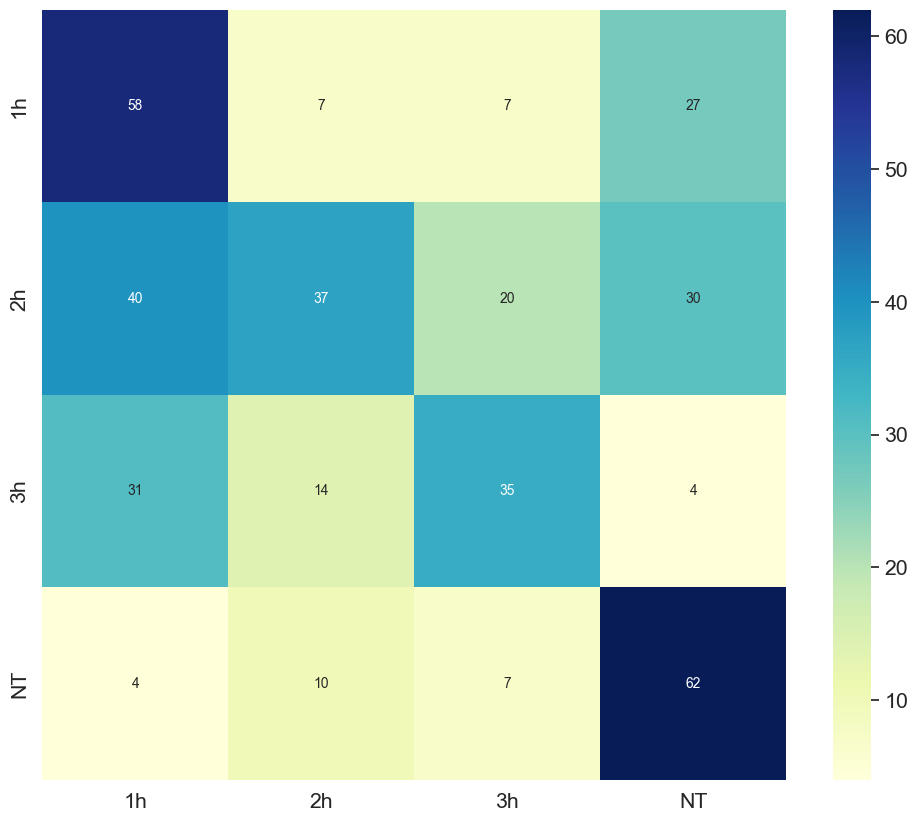

In [51]:
class_names = le.classes_
metrics.confusion_matrix(y_test, preds)
plt.figure(figsize=(12,10))
cm_array = metrics.confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm_array, index = class_names, columns = class_names)

sns.set(font_scale=1.4) # for label size
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 10}, cmap="YlGnBu")
# ax.set(xlabel='Predicted', ylabel='Actual')

# lets look at just predicting healthy and OGD

In [2]:
from azureml.core import Workspace, Dataset

subscription_id = '9c49afdd-cccb-44e2-a4eb-5b2f941c774c'
resource_group = 'schimek_cloud'
workspace_name = 'nels_east_us'

workspace = Workspace(subscription_id, resource_group, workspace_name)

p17_ogd_dataset = Dataset.get_by_name(workspace, name='features_P17_OGD')
p17_ogd_dataset.download(target_path='.', overwrite=True)

p10_ogd_dataset = Dataset.get_by_name(workspace, name='features_P10_OGD')
p10_ogd_dataset.download(target_path='.', overwrite=True)

p17_control_dataset = Dataset.get_by_name(workspace, name='features_P17_control')
p17_control_dataset.download(target_path='.', overwrite=True)

p10_control_dataset = Dataset.get_by_name(workspace, name='features_P10_control')
p10_control_dataset.download(target_path='.', overwrite=True)

['/Users/nelsschimek/Documents/nancelab/diff_predictor/notebooks/azure_notebooks/features_P10_NT_11DIV_40nm_cortex_slice_1_vid_1.csv',
 '/Users/nelsschimek/Documents/nancelab/diff_predictor/notebooks/azure_notebooks/features_P10_NT_4DIV_40nm_cortex_slice_1_vid_3.csv',
 '/Users/nelsschimek/Documents/nancelab/diff_predictor/notebooks/azure_notebooks/features_P10_NT_11DIV_40nm_striatum_slice_1_vid_2.csv',
 '/Users/nelsschimek/Documents/nancelab/diff_predictor/notebooks/azure_notebooks/features_P10_NT_4DIV_40nm_striatum_slice_1_vid_5.csv',
 '/Users/nelsschimek/Documents/nancelab/diff_predictor/notebooks/azure_notebooks/features_P10_NT_14DIV_40nm_cortex_slice_1_vid_2.csv',
 '/Users/nelsschimek/Documents/nancelab/diff_predictor/notebooks/azure_notebooks/features_P10_NT_acute_40nm_cortex_slice_2_vid_1.csv',
 '/Users/nelsschimek/Documents/nancelab/diff_predictor/notebooks/azure_notebooks/features_P10_NT_14DIV_40nm_striatum_slice_1_vid_5.csv',
 '/Users/nelsschimek/Documents/nancelab/diff_predic

In [3]:
datasetpath = getcwd()
print('Current Notebook Dir: ' + datasetpath)

# for file in dataset.to_path():
#     print(file)
#     df = pd.read_csv(workbookDir + file)
#     print(df.shape)
print('generating filelist')
#filelist = [f for f in listdir(dataset.to_path()) if isfile(join(dataset.to_path(), f)) and 'feat' in f]
filelist = []
for file in p17_ogd_dataset.to_path():
    filelist.append(file)
for file in p10_ogd_dataset.to_path():
    filelist.append(file)
for file in p17_control_dataset.to_path():
    filelist.append(file)
for file in p10_control_dataset.to_path():
    filelist.append(file)
print('showing five path examples')
print(filelist[0:5])
print(f'length of filelist: {len(filelist)}')

Current Notebook Dir: /Users/nelsschimek/Documents/nancelab/diff_predictor/notebooks/azure_notebooks
generating filelist
showing five path examples
['/features_P17_1h_OGD_1d_40nm_slice_1_cortex_vid_1.csv', '/features_P17_1h_OGD_1d_40nm_slice_1_striatum_vid_1.csv', '/features_P17_1h_OGD_3d_40nm_slice_1_cortex_vid_1.csv', '/features_P17_1h_OGD_3d_40nm_slice_1_striatum_vid_1.csv', '/features_P17_1h_OGD_acute_40nm_slice_1_cortex_vid_1.csv']
length of filelist: 72


In [4]:
print('running generate_fullstats function on subset filelist')
fstats_tot = generate_fullstats(datasetpath, filelist, ['OGD', 'NT'], 'treatment')
print(fstats_tot.head())

running generate_fullstats function on subset filelist
Adding file /features_P17_1h_OGD_1d_40nm_slice_1_cortex_vid_1.csv size: (2373, 67)
Adding file /features_P17_1h_OGD_1d_40nm_slice_1_striatum_vid_1.csv size: (1609, 67)
Adding file /features_P17_1h_OGD_3d_40nm_slice_1_cortex_vid_1.csv size: (2354, 67)
Adding file /features_P17_1h_OGD_3d_40nm_slice_1_striatum_vid_1.csv size: (1406, 67)
Adding file /features_P17_1h_OGD_acute_40nm_slice_1_cortex_vid_1.csv size: (883, 67)
Adding file /features_P17_1h_OGD_acute_40nm_slice_1_striatum_vid_1.csv size: (2190, 67)
Adding file /features_P17_2h_OGD_1d_40nm_slice_1_cortex_vid_1.csv size: (1106, 67)
Adding file /features_P17_2h_OGD_1d_40nm_slice_1_striatum_vid_1.csv size: (1033, 67)
Adding file /features_P17_2h_OGD_3d_40nm_slice_1_cortex_vid_1.csv size: (2507, 67)
Adding file /features_P17_2h_OGD_3d_40nm_slice_1_striatum_vid_1.csv size: (3276, 67)
Adding file /features_P17_2h_OGD_acute_40nm_slice_1_cortex_vid_1.csv size: (1321, 67)
Adding file /f

In [5]:
feature_list = [
    'alpha', # Fitted anomalous diffusion alpha exponenet
    'D_fit', # Fitted anomalous diffusion coefficient
    'kurtosis', # Kurtosis of track
    'asymmetry1', # Asymmetry of trajecory (0 for circular symmetric, 1 for linear)
    'asymmetry2', # Ratio of the smaller to larger principal radius of gyration
    'asymmetry3', # An asymmetric feature that accnts for non-cylindrically symmetric pt distributions
    'AR', # Aspect ratio of long and short side of trajectory's minimum bounding rectangle
    'elongation', # Est. of amount of extension of trajectory from centroid
    'boundedness', # How much a particle with Deff is restricted by a circular confinement of radius r
    'fractal_dim', # Measure of how complicated a self similar figure is
    'trappedness', # Probability that a particle with Deff is trapped in a region
    'efficiency', # Ratio of squared net displacement to the sum of squared step lengths
    'straightness', # Ratio of net displacement to the sum of squared step lengths
    'MSD_ratio', # MSD ratio of the track
#     'frames', # Number of frames the track spans
    'Deff1', # Effective diffusion coefficient at 0.33 s
    'Deff2', # Effective diffusion coefficient at 3.3 s
    #'angle_mean', # Mean turning angle which is counterclockwise angle from one frame point to another
    #'angle_mag_mean', # Magnitude of the turning angle mean
    #'angle_var', # Variance of the turning angle
    #'dist_tot', # Total distance of the trajectory
    #'dist_net', # Net distance from first point to last point
    #'progression', # Ratio of the net distance traveled and the total distance
    'Mean alpha', 
    'Mean D_fit', 
    'Mean kurtosis', 
    'Mean asymmetry1', 
    'Mean asymmetry2',
    'Mean asymmetry3', 
    'Mean AR',
    'Mean elongation', 
    'Mean boundedness',
    'Mean fractal_dim', 
    'Mean trappedness', 
    'Mean efficiency',
    'Mean straightness', 
    'Mean MSD_ratio', 
    'Mean Deff1', 
    'Mean Deff2',
    ]

target = 'treatment'

In [6]:
ecm = fstats_tot[feature_list + [target, 'Track_ID', 'X', 'Y']]
print(f'initial length of dataset: {len(ecm)}')
ecm = ecm[~ecm[list(set(feature_list) - set(['Deff2', 'Mean Deff2']))].isin([np.nan, np.inf, -np.inf]).any(1)]  
print(f'length after removing NAN/infs: {len(ecm)}')     # Removing nan and inf data points
bal_ecm = balance_data(ecm, target)
sampled_df = bin_data(bal_ecm)
label_df = sampled_df[target]
features_df = sampled_df.drop([target, 'X', 'Y', 'binx', 'biny', 'bins', 'Track_ID'], axis=1)
features = features_df.columns

initial length of dataset: 175106
length after removing NAN/infs: 137800
Ratio before data balance (OGD:NT) = 60971:76829
Ratio after balance (OGD:NT) = 60971:60971


In [8]:
best_param = {'max_depth': 10, 'eta': 0.01, 'min_child_weight': 10, 'verbosity': 0, 'objective': 'multi:softprob', 'num_class': 2, 'silent': 'True', 'gamma': 0.2, 'subsample': 0.15, 'colsample_bytree': 0.8, 'eval_metric': 'mlogloss', }


In [23]:
import random
seed = 1234
random.seed(seed)
print(random.randint(1, 2000))
print(random.randint(1, 2000))
print(random.randint(1, 2000))




1980
1594
903


In [24]:
import tqdm
import random

acc_list = []
true_label_list = []
preds_list = []
seed = 1234
random.seed(seed)

for i in tqdm.notebook.trange(10, desc='1st loop'):


    train_split = 0.8
    test_split = 0.5
#     sampled_filelist = []
#     class_lens = [0, 15, 30, 45, 60, 75] # this is specific to the age data set!
#     for i in range(len(class_lens)-1):
#         rand_integers = random.sample(set(np.arange(class_lens[i], class_lens[i+1])), 15)
#         for rand_int in rand_integers:
#             sampled_filelist.append(filelist[rand_int])
    fstats_tot = generate_fullstats(datasetpath, filelist, ['OGD', 'NT'], 'treatment')

    ecm = fstats_tot[feature_list + [target, 'Track_ID', 'X', 'Y', 'frames', ]]
    ecm = ecm[~ecm[list(set(feature_list) - set(['Deff2', 'Mean Deff2']))].isin([np.nan, np.inf, -np.inf]).any(1)] 

    random_state = random.randint(1, 2000)
    print(random_state)
    bal_ecm = balance_data(ecm, target, random_state=random_state)
    sampled_df = bin_data(bal_ecm)
    label_df = sampled_df[target]
    features_df = sampled_df.drop([target, 'X', 'Y', 'binx', 'biny', 'bins', 'Track_ID', 'frames'], axis=1)
    features = features_df.columns

    

    le = preprocessing.LabelEncoder()
    sampled_df['encoded_target'] = le.fit_transform(sampled_df[target])

    training_bins = np.random.choice(sampled_df['bins'].unique(), int(len(sampled_df['bins'].unique())*train_split), replace=False)

    X_train = sampled_df[sampled_df['bins'].isin(training_bins)]
    X_test_val = sampled_df[~sampled_df['bins'].isin(training_bins)]
    X_val, X_test = train_test_split(X_test_val, test_size=test_split, random_state=seed)

    y_train = X_train['encoded_target']
    y_test = X_test['encoded_target']
    y_val = X_val['encoded_target']

    dtrain = xgb.DMatrix(X_train[features], label=y_train)
    dtest = xgb.DMatrix(X_test[features], label=y_test)
    dval = xgb.DMatrix(X_val[features], label=y_val)
    booster, acc, true_label, preds = train(best_param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=245)
    acc_list.append(acc)
    true_label_list.append(true_label)
    preds_list.append(preds)
   

output_dict = {'Accuracies': acc_list,
               'True Labels': true_label_list,
               'Preds': preds_list,
               'Trajectory Count': traj_count_list,
}

df = pd.DataFrame(output_dict)

1st loop:   0%|          | 0/10 [00:00<?, ?it/s]

Adding file /features_P17_1h_OGD_1d_40nm_slice_1_cortex_vid_1.csv size: (2373, 67)
Adding file /features_P17_1h_OGD_1d_40nm_slice_1_striatum_vid_1.csv size: (1609, 67)
Adding file /features_P17_1h_OGD_3d_40nm_slice_1_cortex_vid_1.csv size: (2354, 67)
Adding file /features_P17_1h_OGD_3d_40nm_slice_1_striatum_vid_1.csv size: (1406, 67)
Adding file /features_P17_1h_OGD_acute_40nm_slice_1_cortex_vid_1.csv size: (883, 67)
Adding file /features_P17_1h_OGD_acute_40nm_slice_1_striatum_vid_1.csv size: (2190, 67)
Adding file /features_P17_2h_OGD_1d_40nm_slice_1_cortex_vid_1.csv size: (1106, 67)
Adding file /features_P17_2h_OGD_1d_40nm_slice_1_striatum_vid_1.csv size: (1033, 67)
Adding file /features_P17_2h_OGD_3d_40nm_slice_1_cortex_vid_1.csv size: (2507, 67)
Adding file /features_P17_2h_OGD_3d_40nm_slice_1_striatum_vid_1.csv size: (3276, 67)
Adding file /features_P17_2h_OGD_acute_40nm_slice_1_cortex_vid_1.csv size: (1321, 67)
Adding file /features_P17_2h_OGD_acute_40nm_slice_1_striatum_vid_1.cs

NameError: name 'traj_count_list' is not defined

In [25]:
acc_list

[0.6620352402390748,
 0.6826205023761032,
 0.6513080827801639,
 0.6611010084311456,
 0.6683133925125434,
 0.6768054905630947,
 0.669065317096315,
 0.6464539296498817,
 0.6512201133842741,
 0.636657280106013]

0.6620352402390748
0.6826205023761032
0.6513080827801639
0.6611010084311456
0.6683133925125434
0.6768054905630947
0.669065317096315
0.6464539296498817
0.6512201133842741
0.636657280106013


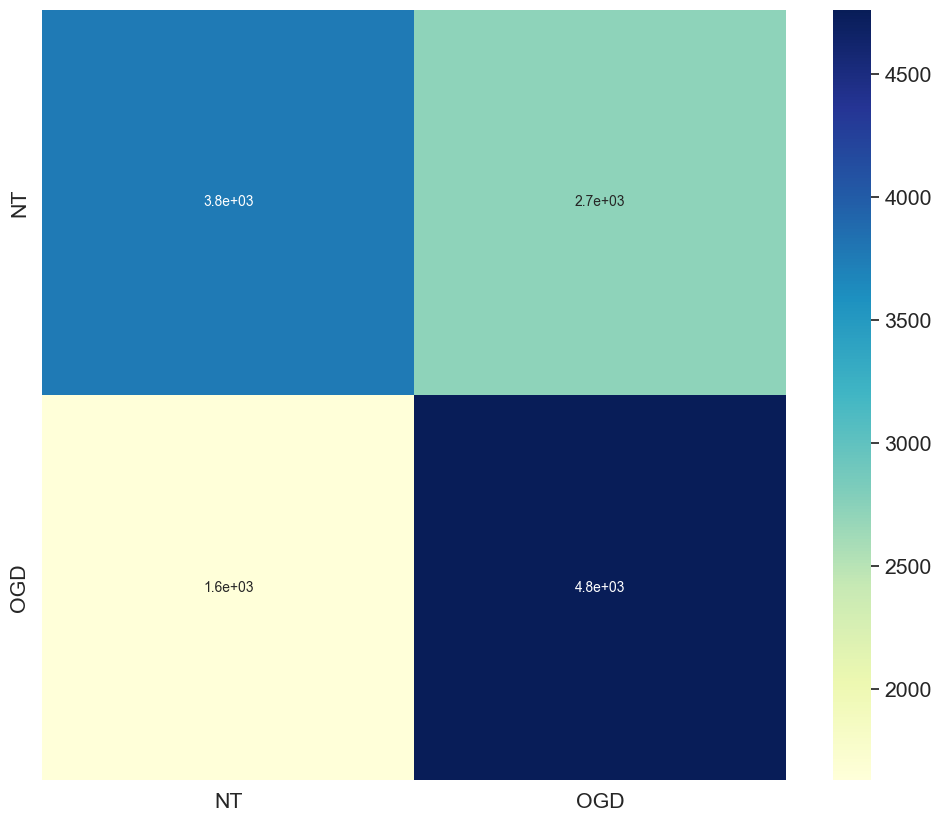

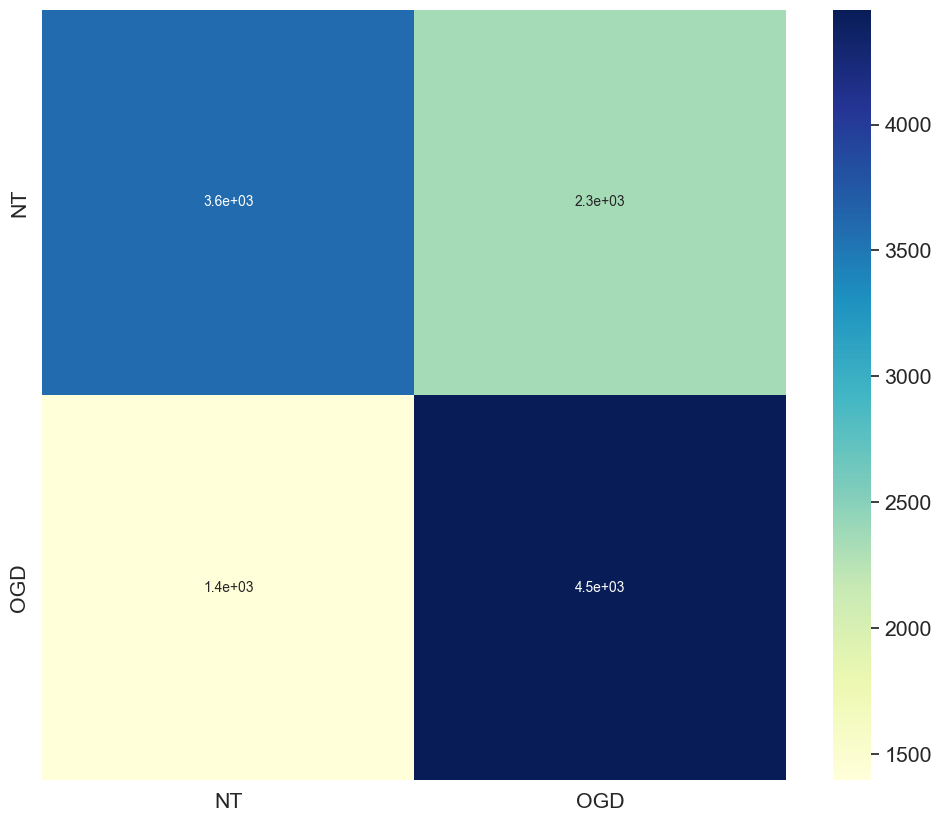

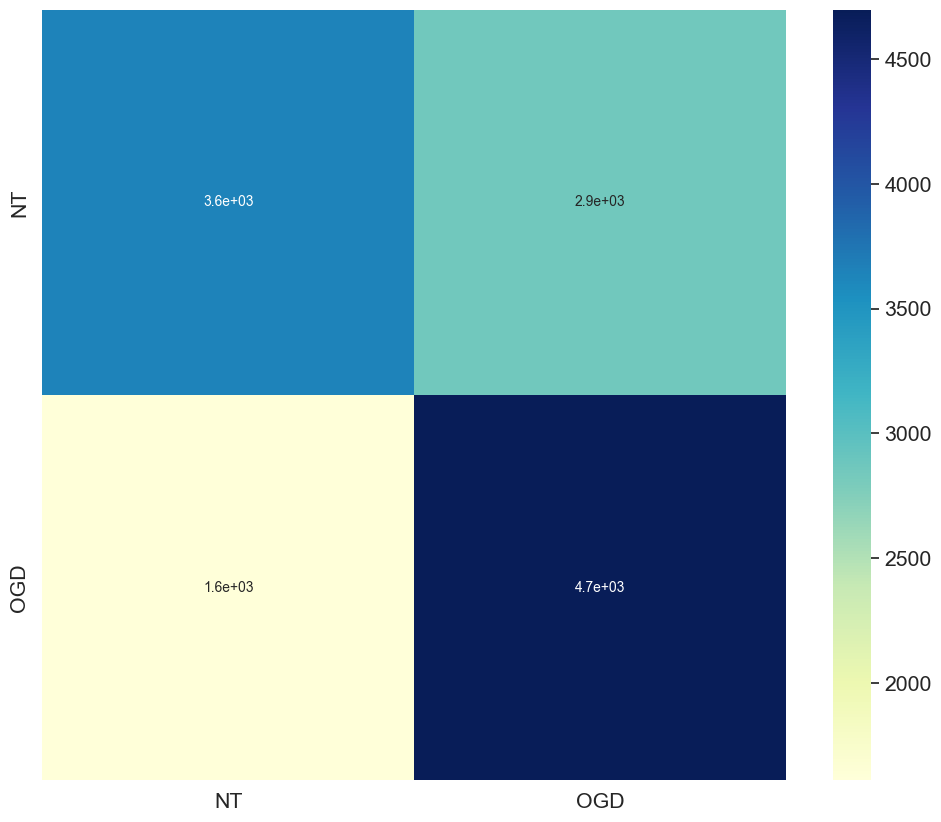

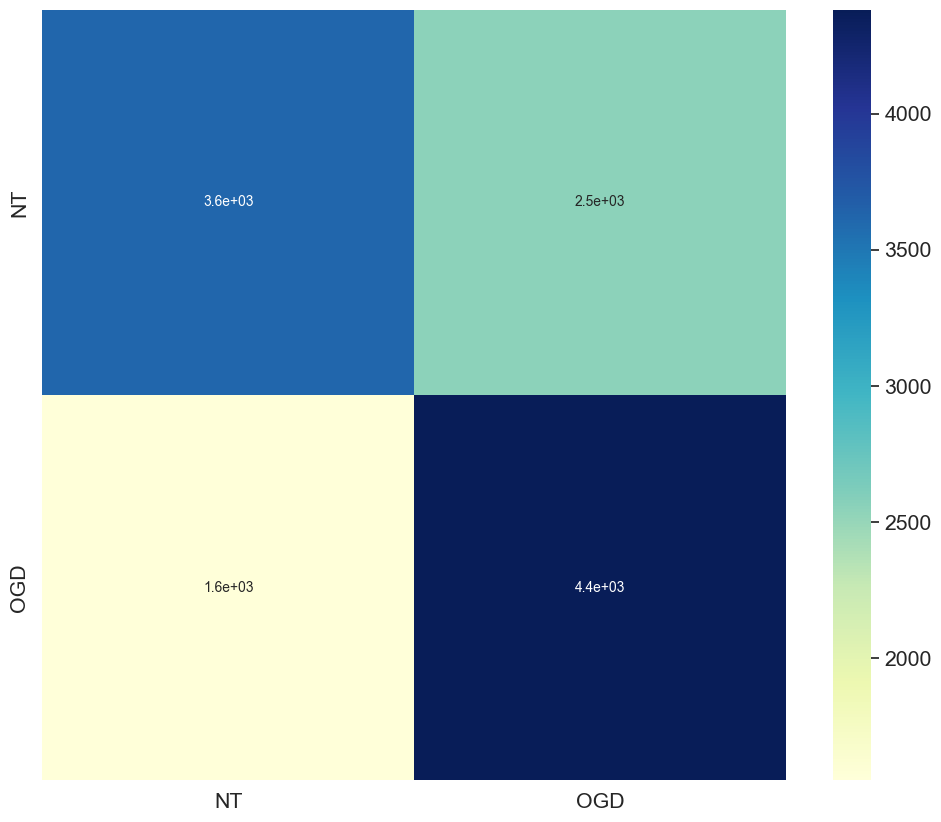

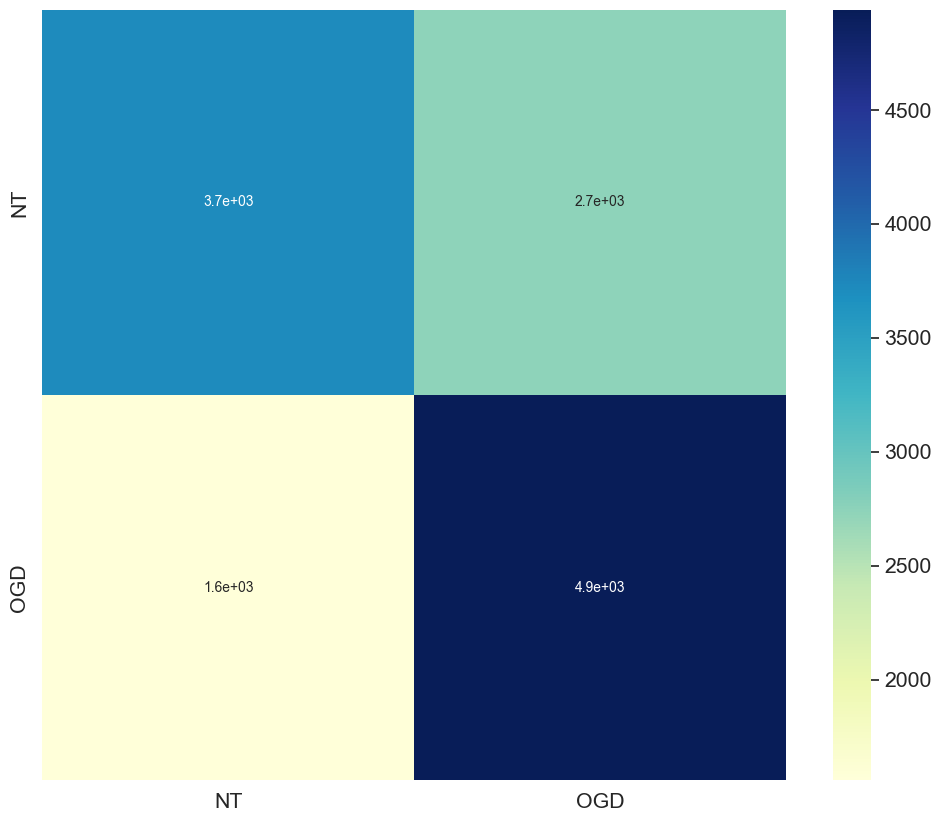

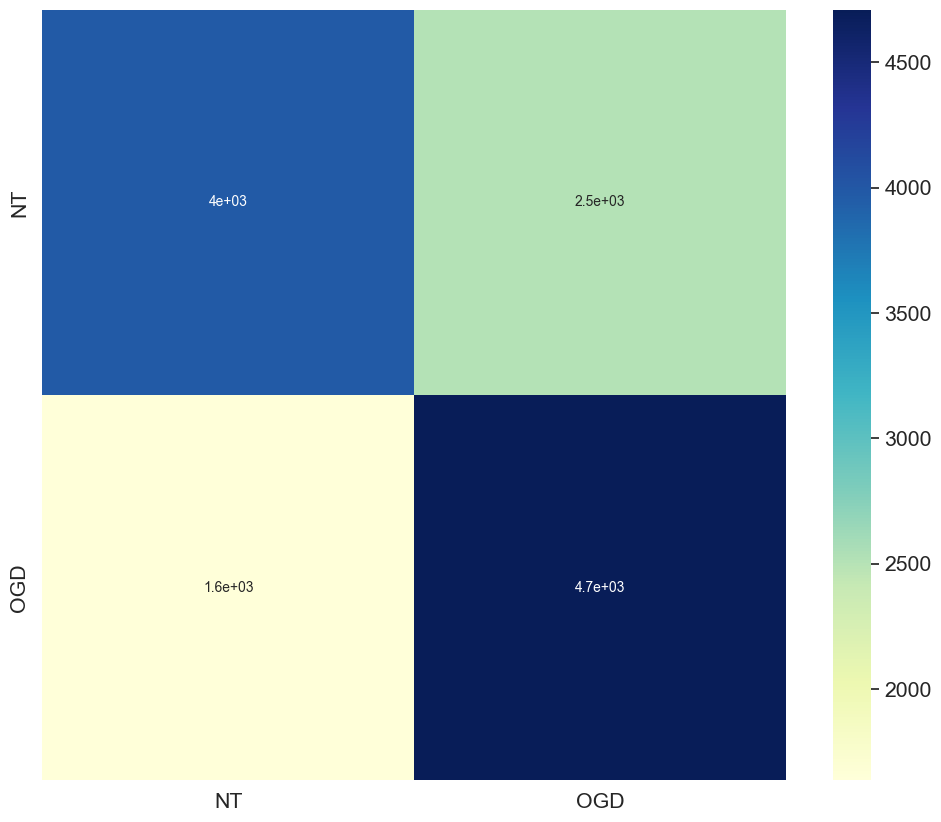

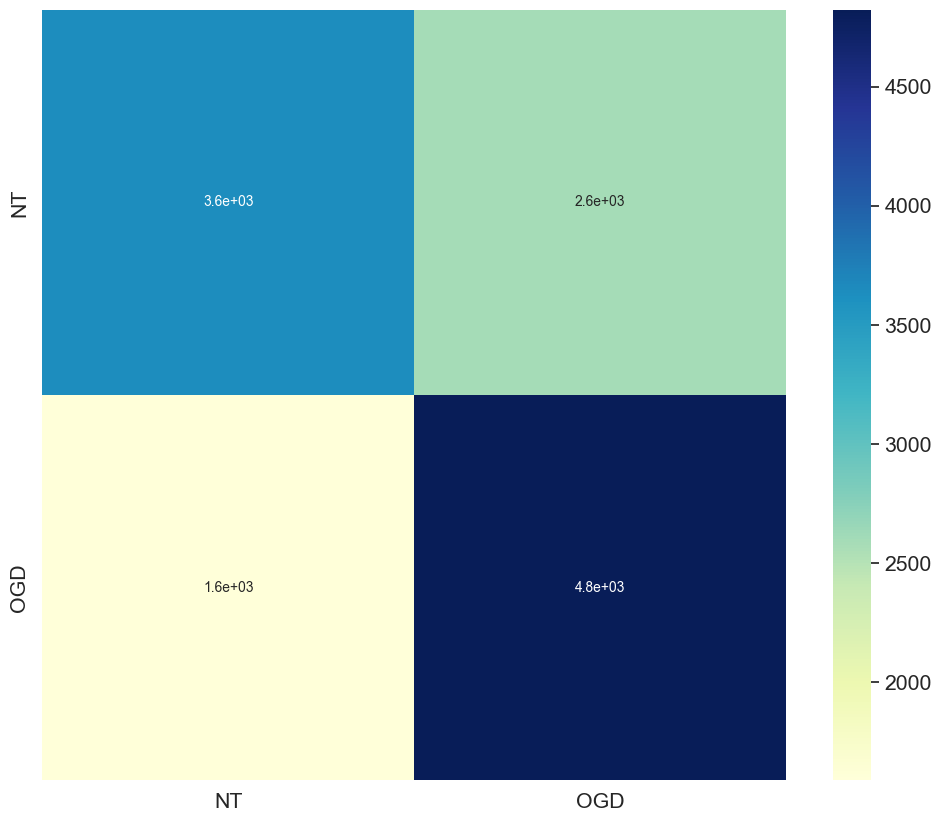

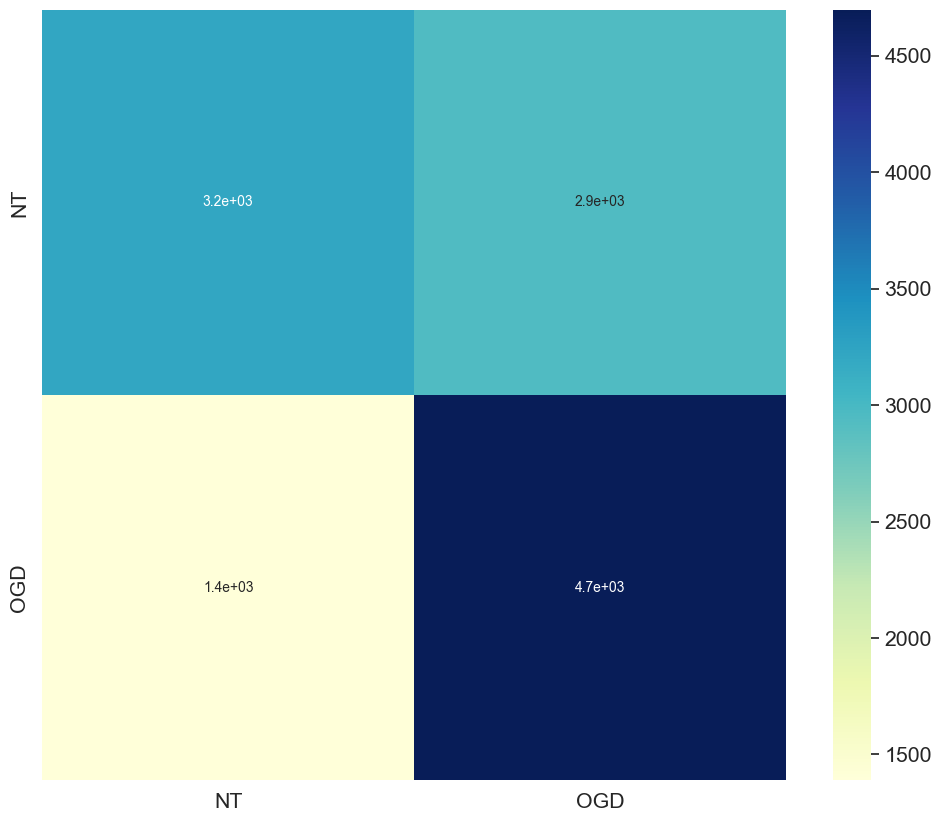

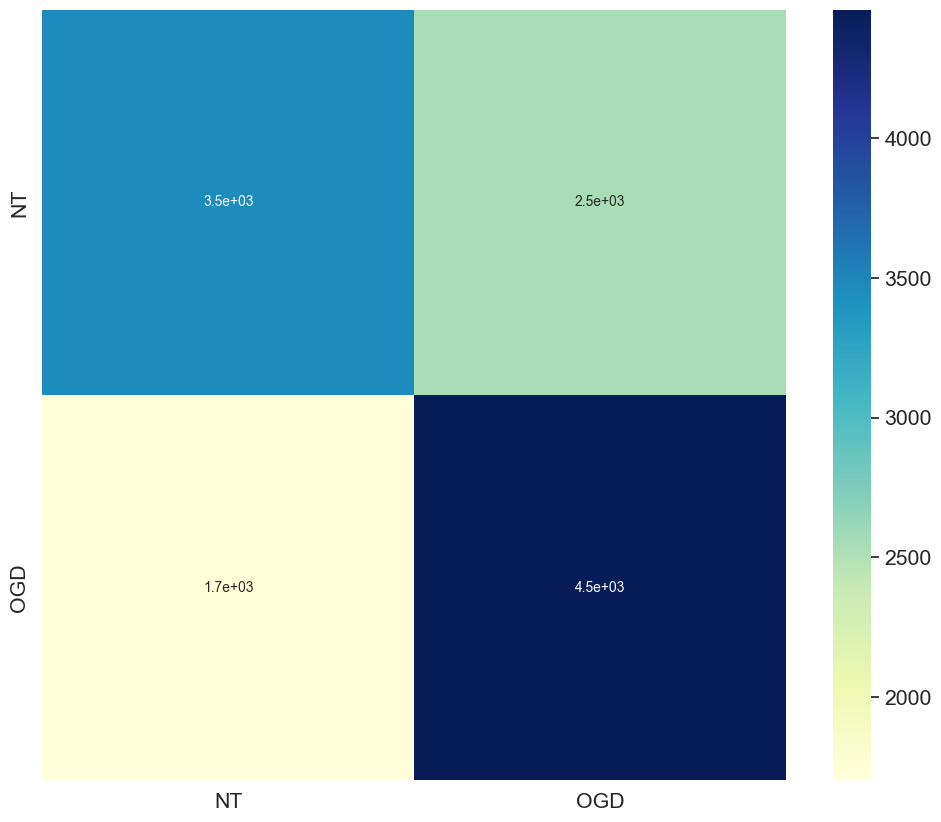

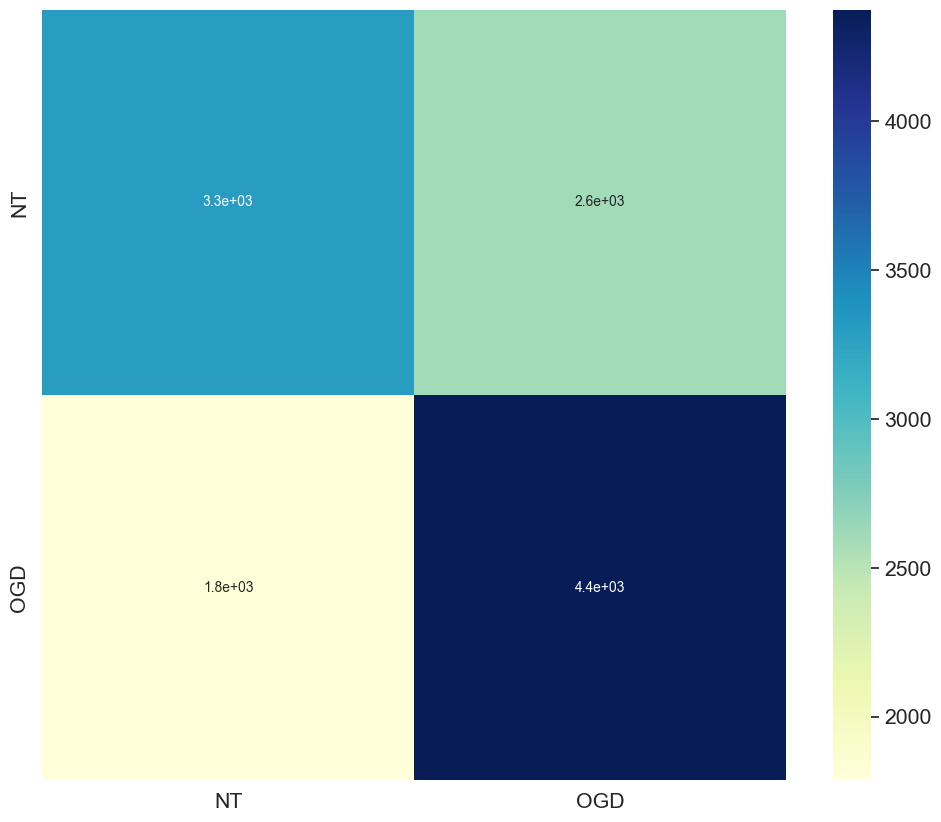

In [28]:
for i in range(len(acc_list)):
    print(acc_list[i])
    class_names = le.classes_
    metrics.confusion_matrix(true_label_list[i], preds_list[i])
    plt.figure(figsize=(12,10))
    cm_array = metrics.confusion_matrix(true_label_list[i], preds_list[i])
    df_cm = pd.DataFrame(cm_array, index = class_names, columns = class_names)

    sns.set(font_scale=1.4) # for label size
    ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 10}, cmap="YlGnBu")
# ax.set(xlabel='Predicted', ylabel='Actual')